In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

from config import Config

In [2]:
config = Config()
print(f'Current device: {config.device}')

Current device: mps


In [3]:
def plot_predictions(X_train: torch.Tensor, y_train: torch.Tensor, X_test: torch.Tensor, y_test: torch.Tensor, y_pred: torch.Tensor) -> None:
    try:
        # Creates the Figure and Axes objects
        fig, ax = plt.subplots(figsize=(12, 6))

        # Scatter plot for training and testing data, and predictions.
        ax.scatter(X_test.cpu().numpy(), y_test.cpu().numpy(), color='darkturquoise', edgecolors='black', label='Test data')
        ax.scatter(X_train.cpu().numpy(), y_train.cpu().numpy(), color='darksalmon', edgecolors='black', label='Train data')
        ax.scatter(X_test.cpu().numpy(), y_pred.detach().cpu().numpy(), color='yellowgreen', edgecolors='black', label='Predictions')
        ax.set_xlabel('X')
        ax.set_ylabel('y')
        ax.set_title('Predictions', loc='left', fontdict={'fontsize': 14, 'fontstyle': 'italic'})
        ax.legend(prop={'size': 10, 'style': 'italic'})
        plt.show()
    except Exception as e:
        print(f"An error occurred while plotting predictions: {e}")

def plot_curves(epoch_count: np.ndarray, train_loss_values: np.ndarray, test_loss_values: np.ndarray) -> None:
    try:
        # Cretes the Figure and Axes objects
        fig, ax = plt.subplots(figsize=(12, 4))
        
        # Plot the training and testing loss values
        ax.plot(epoch_count, train_loss_values, label='Train loss', color='darkturquoise')
        ax.plot(epoch_count, test_loss_values, label='Test loss', color='darksalmon')
        ax.set_title('Loss over epochs', loc='left', fontdict={'fontsize': 14, 'fontstyle': 'italic'})
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.show()
    except Exception as e:
        print(f"An error occurred while plotting curves: {e}")

def save_checkpoint(model: nn.Module, optimizer: optim.Optimizer, epoch: int, loss: float, filename: str) -> None:
    try:
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': loss
        }
        torch.save(checkpoint, filename)
        print(f"Checkpoint saved to {filename}")
    except Exception as e:
        print(f"An error occurred while saving the checkpoint: {e}")

- *Cambiamos un poco el código de nuestro modelo. Ahora vamos a utilizar la clase `nn.Linear`, la cual implementa una transformación lineal sobre los datos de entrada:*
$$
y = W\cdot X + b
$$
- *Tiene tres argumentos:*
    - *`in_features` (`int`). Es la cantidad de valores de entrada que recibe. Se puede pensar como la cantidad de features.*
    - *`out_features` (`int`). Es la cantidad de valores de salida que tiene.*
    - *`bias` (`bool`). Por defecto está definido como `True`. Si se define como `False`, entonces el modelo no aprende ese parámetro.*
- *Esta clase se encarga de crear los tensores (utilizando el modulo `nn.Parameter`) para los parámetros del modelo, por lo que no tenemos que definirlos manualmente como antes.*
- *Vamos a observar ligeras diferencias entre este modelo y el anterior. Esto se debe a la manera en la que se inicializan los parámetros (`nn.Linear` utiliza el método de Kaiming/He mientras que el modelo anterior utilizaba `torch.randn`), la manera en que se ordenan los parámetros cuando usamos `nn.Linear`, y como fueron computados los gradientes.*

In [4]:
class LinearRegressionModel(nn.Module):
    def __init__(self, device: torch.device = torch.device('cpu')):
        '''
        Initializes a LinearRegressionModel.

        Args:
            device (torch.device): Device to run the model on. Defaults to CPU.
        '''
        super().__init__()
        self.linear = nn.Linear(1, 1, dtype=torch.float32) # This is a linear layer with just one input (X) and one output (y)

        self.to(device=device)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.linear(X)
    
# Set random seed for reproducibility
torch.manual_seed(42)

# Instantiate the model
model = LinearRegressionModel(device=config.device)

# Print the model's parameters
print("Model parameters before training:")
model.state_dict()

Model parameters before training:


OrderedDict([('linear.weight', tensor([[0.7645]], device='mps:0')),
             ('linear.bias', tensor([0.8300], device='mps:0'))])

- *Cuando particionamos los datos de entrenamiento y evaluación usando índices, esto nos devuelve un tensor uni-dimensional de tamaño `(n_samples, )`. `nn.Linear` espera recibir un tensor bi-dimensional de tamaño `(batch_size, n_features)`.*
- *Agregamos una dimensión extra (`dim=1`) utilizando el método `unsqueeze()`.*

In [5]:
train_data = torch.load('temp/data/train_data.pth', map_location=config.device)
test_data = torch.load('temp/data/test_data.pth', map_location=config.device)

# When we split the data using [:, 0], this returns a 1D tensor of shape (n_samples, )
# The nn.Linear layer expects a 2D tensor of shape (batch_size, n_features), so we need to add an extra dimension.
X_train = train_data[:, 0].unsqueeze(1)
y_train = train_data[:, 1].unsqueeze(1)
X_test = test_data[:, 0].unsqueeze(1)
y_test = test_data[:, 1].unsqueeze(1)

- *Definimos la función de pérdida y el optimizador que vamos a utilizar. Luego, entrenamos nuestro modelo con el loop que creamos anteriormente.*

In [6]:
loss_function = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

In [7]:
# An epoch is one complete pass through the dataset
epochs = 200

# Creates a NumPy array to store the loss functions values
epoch_count = np.arange(epochs)
train_loss_values = np.zeros(epochs)
test_loss_values = np.zeros(epochs)

for epoch in np.arange(epochs):
    ##### Training Loop #####

    # Set the model to training mode
    model.train()

    # Foward pass
    # We don't have to call the `forward()` method explicitly, because it's called automatically when the model is called
    y_pred = model(X_train)

    # Calculate the loss
    train_loss = loss_function(y_pred, y_train)
    train_loss_values[epoch] = train_loss.item()

    # Zero the gradients
    # This is an important step, because by default, gradients are accumulated in PyTorch
    # If we don't zero the gradients, the gradients will be added to the previous gradients
    optimizer.zero_grad()

    # Backward pass
    # This calculates the gradients of the loss with respect to the model parameters
    train_loss.backward()

    # Update the model parameters
    optimizer.step()

    ### Validation Loop #####

    # Set the model to evaluation mode
    model.eval()

    # Turn on inference mode.
    with torch.inference_mode():
        # Forward pass
        y_test_pred = model(X_test)

        # Calculate the loss for the test set
        test_loss = loss_function(y_test_pred, y_test)
        test_loss_values[epoch] = test_loss.item()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} | Train loss: {train_loss.item()} | Test loss: {test_loss.item()}')

Epoch: 0 | Train loss: 0.5555006265640259 | Test loss: 0.574234664440155
Epoch: 10 | Train loss: 0.1838676929473877 | Test loss: 0.0907827690243721
Epoch: 20 | Train loss: 0.026121830567717552 | Test loss: 0.04376450553536415
Epoch: 30 | Train loss: 0.015359209850430489 | Test loss: 0.029231935739517212
Epoch: 40 | Train loss: 0.006316775921732187 | Test loss: 0.00032589733018539846
Epoch: 50 | Train loss: 0.004055741708725691 | Test loss: 0.004812520928680897
Epoch: 60 | Train loss: 0.015268802642822266 | Test loss: 0.0064289928413927555
Epoch: 70 | Train loss: 0.005371902137994766 | Test loss: 0.008485632948577404
Epoch: 80 | Train loss: 0.005231654737144709 | Test loss: 0.0005596756818704307
Epoch: 90 | Train loss: 0.00494661508128047 | Test loss: 0.00512067973613739
Epoch: 100 | Train loss: 0.010134114883840084 | Test loss: 0.00901254452764988
Epoch: 110 | Train loss: 0.003858246374875307 | Test loss: 0.004092935007065535
Epoch: 120 | Train loss: 0.010250930674374104 | Test loss: 0

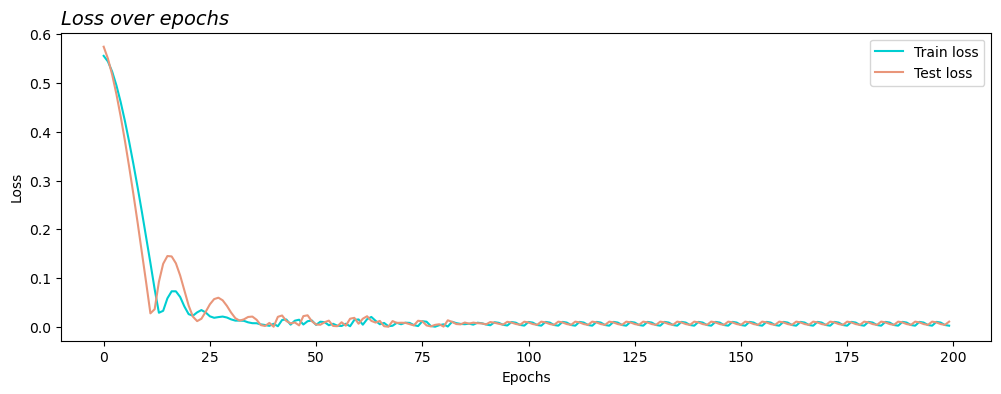

In [8]:
plot_curves(epoch_count, train_loss_values, test_loss_values)

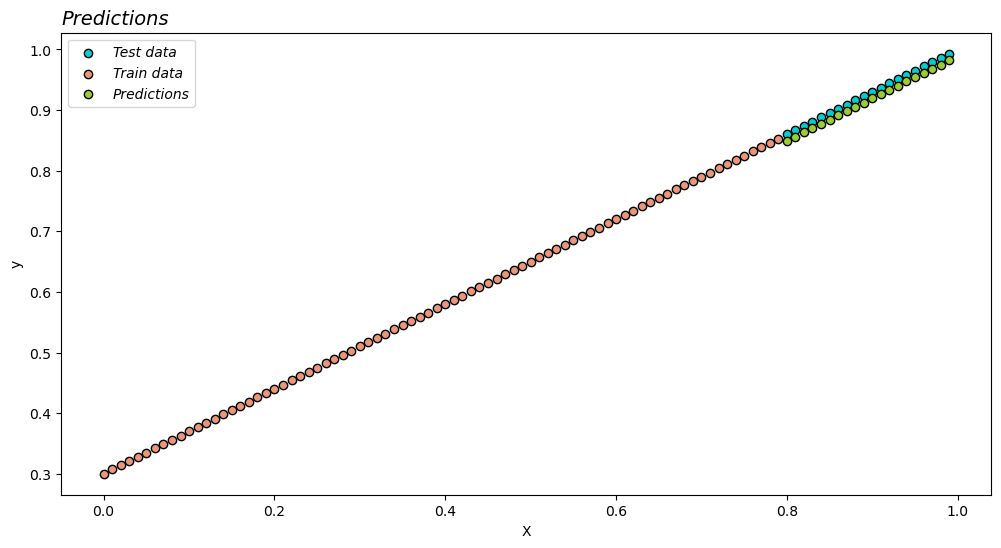

In [9]:
plot_predictions(X_train, y_train, X_test, y_test, y_test_pred)

### Guardar un modelo

- *Una vez que entrenamos y evaluamos nuestro modelo, es muy importante guardarlo. Con guardar los pesos es suficiente (y también es lo recomendable).*
- *Podemos acceder a los parámetros (entrenables) de nuestro modelo a través de `torch.nn.Module.state_dict()`. Este es un diccionario que contiene el estado actual de los parámetros del modelo.*
- *Para guardar los parámetros del modelo utilizamos la función `torch.save()`, la cual implementa la librería `pickle` que nos permite serializar/deserializar objetos de Python. Le tenemos que pasar el objeto que queremos guardar, en nuestro caso `torch.nn.Module.state_dict()`, y el directorio en donde lo queremos guardar.*
    - *La convención es utilizar `.pt` o `.pth` como la extensión del archivo.*

- *Para más información sobre como guardar un modelo y las distintas opciones que hay, consultar este [artículo](https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended).*

In [10]:
# Save the model
print('Saving the model...')
torch.save(model.state_dict(), f'models/model_0.pth')
print('Model saved successfully')

Saving the model...
Model saved successfully


- *Podemos cargar un modelo utilizando la función `torch.nn.Module.load_state_dict()`. Notar que primero tenemos que crear una nueva instancia de nuestro modelo, con los parámetros iniciados aleatoriamente, y luego reemplazar los parámetros por los que guardamos.*
- *También es importante entender que la función `torch.nn.Module.load_state_dict()` acepta un diccionario, y no la ruta en donde está guardado el objeto. Esto quiere decir que primero tenemos que cargar el objeto, usando la función `torch.load()`, y luego actualizar los pesos del modelo con la función `torch.nn.Module.load_state_dict()`.*

In [11]:
# Create a new model instance
model = LinearRegressionModel(device=config.device)
print("Model's randomly initialized parameters:")
print(model.state_dict())

# Load the model's parameters. We only load the parameters, not the entire model
parameters = torch.load(f'models/model_0.pth', weights_only=True)

# Update the model's parameters with the loaded parameters
model.load_state_dict(parameters)
print("Trained model parameters:")
print(model.state_dict())

Model's randomly initialized parameters:
OrderedDict([('linear.weight', tensor([[-0.2343]], device='mps:0')), ('linear.bias', tensor([0.9186], device='mps:0'))])
Trained model parameters:
OrderedDict([('linear.weight', tensor([[0.6990]], device='mps:0')), ('linear.bias', tensor([0.2902], device='mps:0'))])


- *Validamos que las predicciones sean las mismas que antes:*

Are the predictions the same as before? True


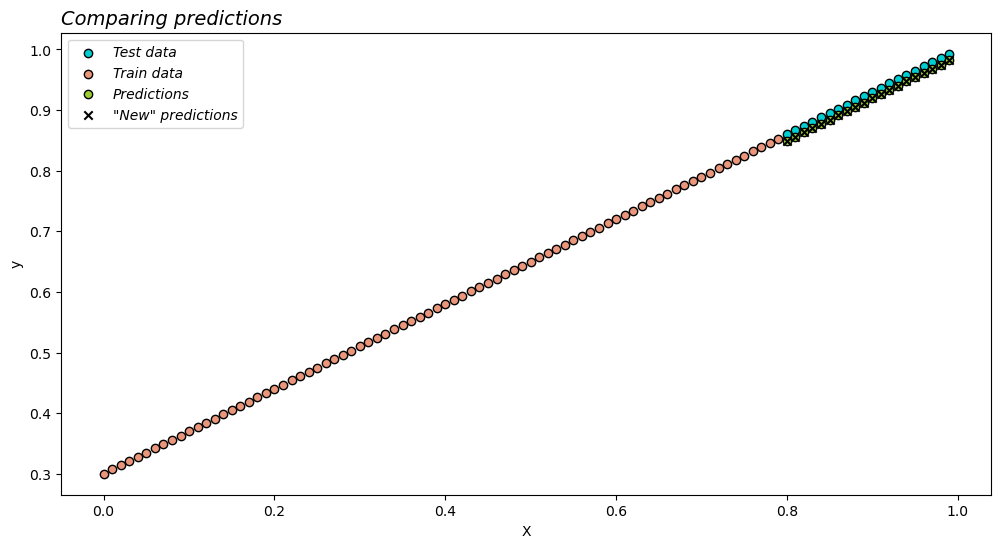

In [12]:
model.eval()
with torch.inference_mode():
    predictions = model(X_test)

print(f'Are the predictions the same as before? {torch.equal(predictions, y_test_pred)}')

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(X_test.cpu().numpy(), y_test.cpu().numpy(), color='darkturquoise', edgecolors='black', label='Test data')
ax.scatter(X_train.cpu().numpy(), y_train.cpu().numpy(), color='darksalmon', edgecolors='black', label='Train data')
ax.scatter(X_test.cpu().numpy(), y_test_pred.detach().cpu().numpy(), color='yellowgreen', edgecolors='black', label='Predictions')
ax.scatter(X_test.cpu().numpy(), predictions.detach().cpu().numpy(), color='black', marker='x', label='"New" predictions')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('Comparing predictions', loc='left', fontdict={'fontsize': 14, 'fontstyle': 'italic'})
ax.legend(prop={'size': 10, 'style': 'italic'})
plt.show()

- *Es también posible ir guardando checkpoints durante el entrenamiento del modelo, para así poder continuar con el entrenamiento más tarde.*
- *En estos casos, es necesario guardar más información que sólo los pesos del modelo. También necesitamos guardar el estado actual de los parámetros del optimizador (el cual tiene su propio `torch.optim.Optimizer.state_dict()`), la época en la que estamos, el valor de la función de pérdida, entre otros.*
    - *Es una convención guardar estos checkpoints utilizando la extensión `.tar`.*
- *Para guardar un checkpoint, debemos organizar los elementos en un diccionario y luego utilizar `torch.save()` para serializar el objeto.*

In [13]:
# Create a new model instance
model = LinearRegressionModel(device=config.device)

# Create a new loss function
loss_function = nn.L1Loss()

# Create a new optimizer instance
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)

In [14]:
# An epoch is one complete pass through the dataset
epochs = 200

# Creates a NumPy array to store the loss functions values
epoch_count = np.arange(epochs)
train_loss_values = np.zeros(epochs)
test_loss_values = np.zeros(epochs)

for epoch in np.arange(epochs):
    ##### Training Loop #####

    # Set the model to training mode
    model.train()

    # Foward pass
    # We don't have to call the `forward()` method explicitly, because it's called automatically when the model is called
    y_pred = model(X_train)

    # Calculate the loss
    train_loss = loss_function(y_pred, y_train)
    train_loss_values[epoch] = train_loss.item()

    # Zero the gradients
    # This is an important step, because by default, gradients are accumulated in PyTorch
    # If we don't zero the gradients, the gradients will be added to the previous gradients
    optimizer.zero_grad()

    # Backward pass
    # This calculates the gradients of the loss with respect to the model parameters
    train_loss.backward()

    # Update the model parameters
    optimizer.step()

    ### Validation Loop #####

    # Set the model to evaluation mode
    model.eval()

    # Turn on inference mode.
    with torch.inference_mode():
        # Forward pass
        y_test_pred = model(X_test)

        # Calculate the loss for the test set
        test_loss = loss_function(y_test_pred, y_test)
        test_loss_values[epoch] = test_loss.item()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} | Train loss: {train_loss.item()} | Test loss: {test_loss.item()}')
            save_checkpoint(model, optimizer, epoch, train_loss.item(), f'temp/checkpoints/model_0_epoch_{epoch}.tar')

Epoch: 0 | Train loss: 0.4612552225589752 | Test loss: 0.9072718024253845
Checkpoint saved to temp/checkpoints/model_0_epoch_0.tar
Epoch: 10 | Train loss: 0.18000714480876923 | Test loss: 0.4678269326686859
Checkpoint saved to temp/checkpoints/model_0_epoch_10.tar
Epoch: 20 | Train loss: 0.14208459854125977 | Test loss: 0.2616625428199768
Checkpoint saved to temp/checkpoints/model_0_epoch_20.tar
Epoch: 30 | Train loss: 0.1212395578622818 | Test loss: 0.2830166220664978
Checkpoint saved to temp/checkpoints/model_0_epoch_30.tar
Epoch: 40 | Train loss: 0.1042957678437233 | Test loss: 0.2442026436328888
Checkpoint saved to temp/checkpoints/model_0_epoch_40.tar
Epoch: 50 | Train loss: 0.08714315295219421 | Test loss: 0.19725105166435242
Checkpoint saved to temp/checkpoints/model_0_epoch_50.tar
Epoch: 60 | Train loss: 0.07001107186079025 | Test loss: 0.15947067737579346
Checkpoint saved to temp/checkpoints/model_0_epoch_60.tar
Epoch: 70 | Train loss: 0.052877821028232574 | Test loss: 0.12104

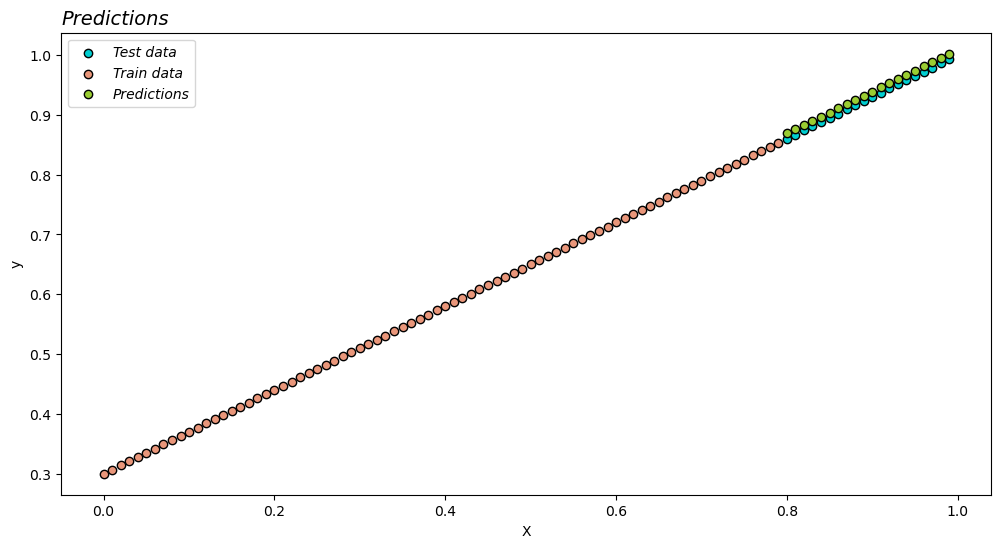

In [15]:
plot_predictions(X_train, y_train, X_test, y_test, y_test_pred)

- *Luego, para acceder los checkpoints, utilizamos la función `torch.load()` para inicializar el diccionario que guardamos.*
- *Recordar que es necesario crear una nueva instancia del modelo y del optimizador para continuar con el entrenamiento del modelo a partir de ese checkpoint.*

In [17]:
# Create a new model instance for loading the checkpoint
model_80 = LinearRegressionModel(device=config.device)

# Creates a new optimizer instance
optimizer_80 = optim.SGD(model_80.parameters(), lr=0.01, momentum=0.8)

# Load the checkpoint
checkpoint = torch.load('temp/checkpoints/model_0_epoch_80.tar', weights_only=False, map_location=config.device)

# Load the model state dict
model_80.load_state_dict(checkpoint['model_state_dict'])

# Load the optimizer state dict
optimizer_80.load_state_dict(checkpoint['optimizer_state_dict'])

# Load the epoch and loss
epoch_80 = checkpoint['epoch']
loss_80 = checkpoint['loss']

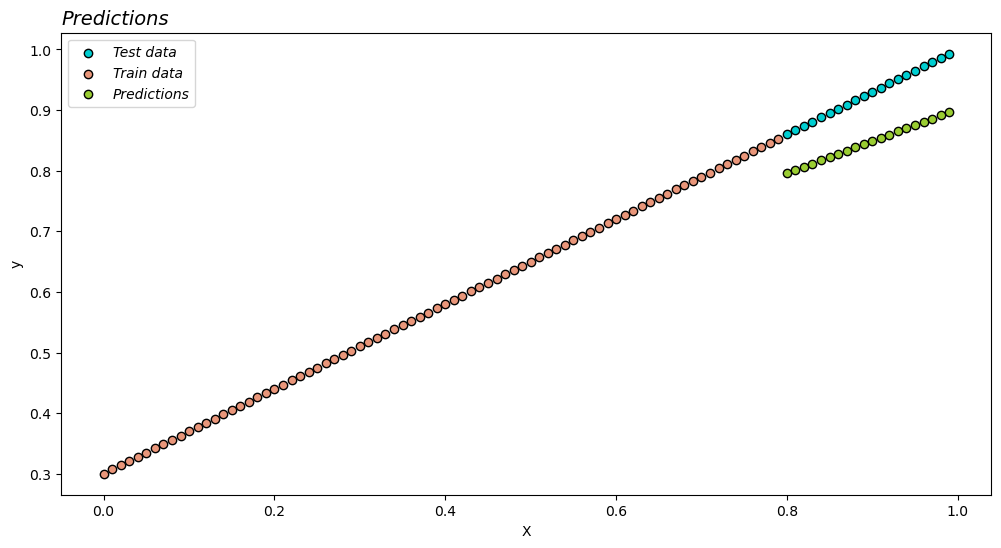

In [18]:
model_80.eval()
with torch.inference_mode():
    predictions_80 = model_80(X_test)

plot_predictions(X_train, y_train, X_test, y_test, predictions_80)